# Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Before we perform any analysis, it might be useful to take a look at the data we're hoping to analyze. More specifically, let's examine the hourly entries in our NYC subway data and determine what distribution the data follows. This data is stored in a dataframe called `turnstile_weather` under the `['ENTRIESn_hourly']` column.
    
Let's plot two histograms on the same axes to show hourly entries when raining vs. when not raining. Here's an example on how to plot histograms with pandas and matplotlib:
```
turnstile_weather['column_to_graph'].hist()
```
    
Your histogram may look similar to bar this:
![histogram](01.png)

<module 'matplotlib.pyplot' from '/Users/snewman/.Envs/sandbox/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

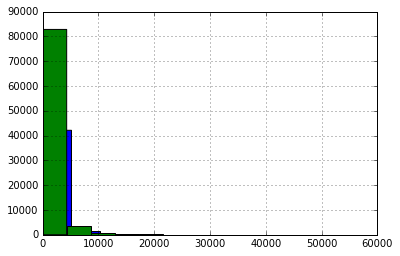

In [16]:
%matplotlib inline

def entries_histogram(turnstile_weather):
    plt.figure()
    turnstile_weather[turnstile_weather['rain'] == 1]['ENTRIESn_hourly'].hist()
    turnstile_weather[turnstile_weather['rain'] == 0]['ENTRIESn_hourly'].hist()
    return plt

turnstile_weather = pd.read_csv('turnstile_data_master_with_weather.csv')
entries_histogram(turnstile_weather)

# Mann-Whitney U-Test

In [2]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats

This function will consume the `turnstile_weather` dataframe containing our final turnstile weather data. 
    
You will want to take the means and run the Mann Whitney U-test on the `ENTRIESn_hourly` column in the `turnstile_weather` dataframe.
    
This function should return:
1. the mean of entries with rain
2. the mean of entries without rain
3. the Mann-Whitney U-statistic and p-value comparing the number of entries with rain and the number of entries without rain
    
You should feel free to use scipy's Mann-Whitney implementation, and you might also find it useful to use numpy's `mean` function.
    
Here are the functions' documentation:
- http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
- http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html

In [7]:
def mann_whitney_plus_means(turnstile_weather):
    with_rain = turnstile_weather[turnstile_weather['rain'] == 1]['ENTRIESn_hourly']
    without_rain = turnstile_weather[turnstile_weather['rain'] == 0]['ENTRIESn_hourly']
    U, p = scipy.stats.mannwhitneyu(with_rain, without_rain)
    with_rain_mean = np.mean(with_rain)
    without_rain_mean = np.mean(without_rain)
    return with_rain_mean, without_rain_mean, U, p

turnstile_weather = pd.read_csv('turnstile_data_master_with_weather.csv')
mann_whitney_plus_means(turnstile_weather)

AttributeError: 'module' object has no attribute 'mannwhitney'

# Linear Regression

The NYC turnstile data is stored in a pandas dataframe called `weather_turnstile`. Using the information stored in the dataframe, let's predict the ridership of the NYC subway using linear regression with gradient descent.
    
You can download the complete turnstile weather dataframe here:
https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv    
    
Your prediction should have a R^2 value of `0.40` or better.

You need to experiment using various input features contained in the dataframe. We recommend that you don't use the `EXITSn_hourly` feature as an input to the  linear model because we cannot use it as a predictor: we cannot use exits counts as a way to predict entry counts. 
    
Note: Due to the memory and CPU limitation of our Amazon EC2 instance, we will give you a random subet (~15%) of the data contained in `turnstile_data_master_with_weather.csv`. You are encouraged to experiment with this computer on your own computer, locally. 
    
If you'd like to view a plot of your cost history, uncomment the call to `plot_cost_history` below. The slowdown from plotting is significant, so if you are timing out, the first thing to do is to comment out the plot command again.
    
If you receive a "server has encountered an error" message, that means you are hitting the 30-second limit that's placed on running your program. Try using a smaller number for `num_iterations` if that's the case.
    
If you are using your own algorithm/models, see if you can optimize your code so that it runs faster.

In this question, you need to:
1. implement the `compute_cost()` and `gradient_descent()` procedures
2. Select features (in the predictions procedure) and make predictions.

In [14]:
import numpy as np
import pandas as pd
from ggplot import *

In [24]:
def normalize_features(df):
    """
    Normalize the features in the data set.
    """
    mu = df.mean()
    sigma = df.std()
    
    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()

    return df_normalized, mu, sigma


def compute_cost(features, values, theta):
    """
    Compute the cost of a list of parameters, theta, given a list of features 
    (input data points) and values (output data points).
    """
    m = len(values)
    sum_of_square_errors = np.square(np.dot(features, theta) - values).sum()
    cost = sum_of_square_errors / (2*m)
    return cost


def gradient_descent(features, values, theta, alpha, num_iterations):
    """
    Perform gradient descent given a data set with an arbitrary number of features.
    """
    m = len(values) # number of data points
    cost_history = []
    for i in range(num_iterations):
        predicted_values = np.dot(features, theta)
        theta = theta - alpha / m * np.dot((predicted_values - values), features)
        cost = compute_cost(features, values, theta)
        cost_history.append(cost)

    return theta, pd.Series(cost_history) # leave this line for the grader


def predictions(dataframe):

    # Select Features (try different features!)
    features = dataframe[['rain', 'precipi', 'Hour', 'meantempi']]
    
    # Add UNIT to features using dummy variables
    dummy_units = pd.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe['ENTRIESn_hourly']
    m = len(values)

    features, mu, sigma = normalize_features(features)
    features['ones'] = np.ones(m) # Add a column of 1s (y intercept)
    
    # Convert features and values to numpy arrays
    features_array = np.array(features)
    values_array = np.array(values)

    # Set values for alpha, number of iterations.
    alpha = 0.1 # please feel free to change this value
    num_iterations = 75 # please feel free to change this value

    # Initialize theta, perform gradient descent
    theta_gradient_descent = np.zeros(len(features.columns))
    theta_gradient_descent, cost_history = gradient_descent(features_array, 
                                                            values_array, 
                                                            theta_gradient_descent, 
                                                            alpha, 
                                                            num_iterations)
    
    plot = None
    # -------------------------------------------------
    # Uncomment the next line to see your cost history
    # -------------------------------------------------
    # plot = plot_cost_history(alpha, cost_history)
    # 
    # Please note, there is a possibility that plotting
    # this in addition to your calculation will exceed 
    # the 30 second limit on the compute servers.
    
    predictions = np.dot(features_array, theta_gradient_descent)
    return predictions, plot


def plot_cost_history(alpha, cost_history):
   """This function is for viewing the plot of your cost history.
   You can run it by uncommenting this

       plot_cost_history(alpha, cost_history) 

   call in predictions.
   
   If you want to run this locally, you should print the return value
   from this function.
   """
   cost_df = pd.DataFrame({
      'Cost_History': cost_history,
      'Iteration': range(len(cost_history))
   })
   return ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
      geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha )




In [25]:
df = pd.read_csv('turnstile_data_master_with_weather.csv')
predictions(df)

(array([ 3379.34466358,  3648.71075058,  3918.07683757, ...,   856.38536737,
          856.38536737,   856.38536737]), None)

# Plotting Residuals

Using the same methods that we used to plot a histogram of entries per hour for our data, why don't you make a histogram of the residuals (that is, the difference between the original hourly entry data and the predicted values). Try different binwidths for your histogram.

Based on this residual histogram, do you have any insight into how our model performed?

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def plot_residuals(turnstile_weather, predictions):
    plt.figure()
    (turnstile_weather['ENTRIESn_hourly'] - predictions).hist(bins=50)
    return plt

# Compute R^2

In exercise 5, we calculated the R^2 value for you. But why don't you try and and calculate the R^2 value yourself.
    
Given a list of original data points, and also a list of predicted data points, write a function that will compute and return the coefficient of determination (R^2) for this data. `numpy.mean()` and `numpy.sum()` might both be useful here, but not necessary.

*Note: I could not get this exercise to work.*